# Preliminary

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('dcs')
%aimport dcs 

import pandas as pd
import numpy as np

In [3]:
dataset_name = 'support'
test_size = .2
random_seed = 40

# Dataset

In [4]:
dataset = dcs.datasets.get_dataset(dataset_name)
pipeline = dcs.pipelines.get_pipeline(dataset_name)
display(dataset.head())

train_X, train_y, test_X, test_y = dcs.preprocessing.train_test_split_X_y(
    dataset,
    random_state=random_seed,
    test_size=test_size)

train_X_t = pipeline.fit_transform(train_X)
test_X_t = pipeline.transform(test_X)

display(train_X_t.head())

,event_days,has_event,age,sex,race,no_comorbidities,diabetes,dementia,cancer,mean_arterial_blood_pressure,heart_rate,respiration_rate,temperature,no_white_blood_cells,serum_sodium,serum_creatinine
patient_id,,,,,,,,,,,,,,,,
s-0000,30.0,1,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854
s-0001,1527.0,0,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902
s-0002,96.0,1,23.399990,1.0,2.0,3.0,0.0,0.0,1.0,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951
s-0003,892.0,0,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927
s-0004,7.0,1,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963


,age,sex,no_comorbidities,diabetes,dementia,mean_arterial_blood_pressure,heart_rate,respiration_rate,temperature,no_white_blood_cells,...,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_7.0,race_8.0,race_9.0,cancer_1.0,cancer_2.0
patient_id,,,,,,,,,,,,,,,,,,,,,
s-2015,0.705584,0.0,-0.400374,0.0,0.0,0.296886,-0.471875,-0.372758,-0.562731,-0.746259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s-1795,0.186970,0.0,-0.400374,0.0,0.0,1.403533,-1.492248,-0.797315,-0.165417,0.406433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
s-3146,-0.267826,1.0,-0.400374,0.0,0.0,-0.662208,1.206803,-1.434150,0.709912,1.229784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s-4791,0.876985,0.0,-0.400374,0.0,0.0,0.665768,0.778904,-0.372758,-0.246121,0.077092,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s-6658,-1.213508,1.0,-0.400374,0.0,0.0,1.846192,1.042226,0.264077,0.387095,0.900444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Models

In [5]:
predictions = {}

## CoxPH

In [6]:
cox = dcs.models.CoxPH()
cox.fit(train_X_t, train_y)
predictions['CoxPH'] = cox.predict(test_X_t)

## DeepSurv

In [7]:
deepsurv = dcs.models.DeepSurv()
deepsurv.fit(train_X_t, train_y)
predictions['DeepSurv'] = deepsurv.predict(test_X_t)

## CoxTime

In [8]:
coxtime = dcs.models.CoxTime()
coxtime.fit(train_X_t, train_y)
predictions['CoxTime'] = coxtime.predict(test_X_t)

/home/pfuhlert/src/discrete-calibrated-survival/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass copy=True, with_mean=True, with_std=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## DRSA

In [9]:
train_max_months = int(np.ceil(train_y['event_days'].max() * 12 / 365))
nns_epochs = 100

drsa = dcs.models.Drsa(
    epochs=nns_epochs, 
    use_early_stopping=True,
    early_stopping_patience=10,
    batch_size=50,
    output_grid_num_nodes=train_max_months,
    learning_rate = 1e-4,
    validation_size=.1
    )
drsa.fit(train_X_t, train_y)
predictions['DRSA'] = drsa.predict(test_X_t)

## Kamran

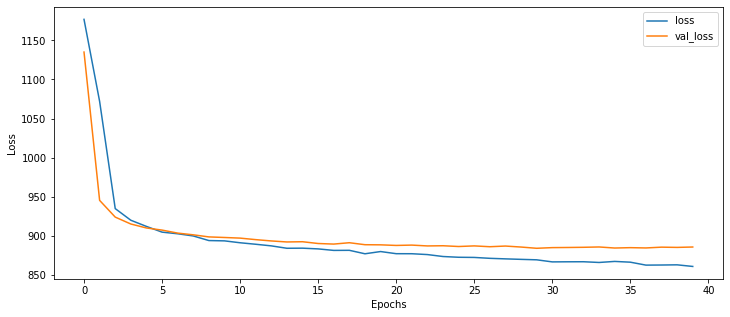

In [10]:
kamran = dcs.models.Kamran(
    epochs=nns_epochs, 
    use_early_stopping=True,
    early_stopping_patience=10,
    batch_size=50,
    learning_rate = 1e-4,
    sigma=0.7,
    lambda_=1,
    output_grid_num_nodes=train_max_months,
    validation_size=.1)

kamran.fit(train_X_t, train_y)
kamran.plot_history()

predictions['Kamran'] = kamran.predict(test_X_t)

## DCS

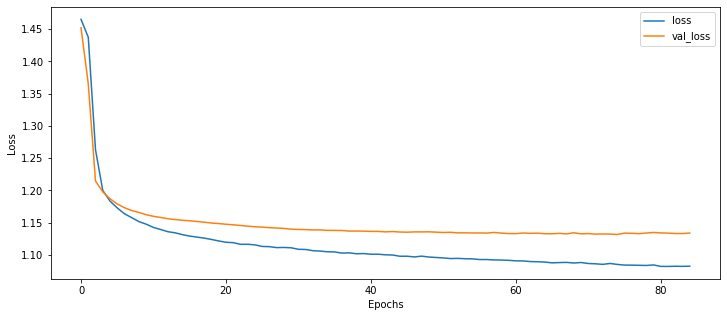

In [11]:
dcs_model = dcs.models.DcsModel(
    epochs=nns_epochs, 
    use_early_stopping=True,
    early_stopping_patience=10,
    batch_size=50,
    learning_rate = 1e-4,
    sigma=0.7,
    lambda_=1,
    output_grid_type='quantile',
    output_grid_num_nodes=train_max_months,
    validation_size=.1)

dcs_model.fit(train_X_t, train_y)
dcs_model.plot_history()

predictions['DCS-Model'] = dcs_model.predict(test_X_t)

# Evaluation

## Qualitative Survival Curves

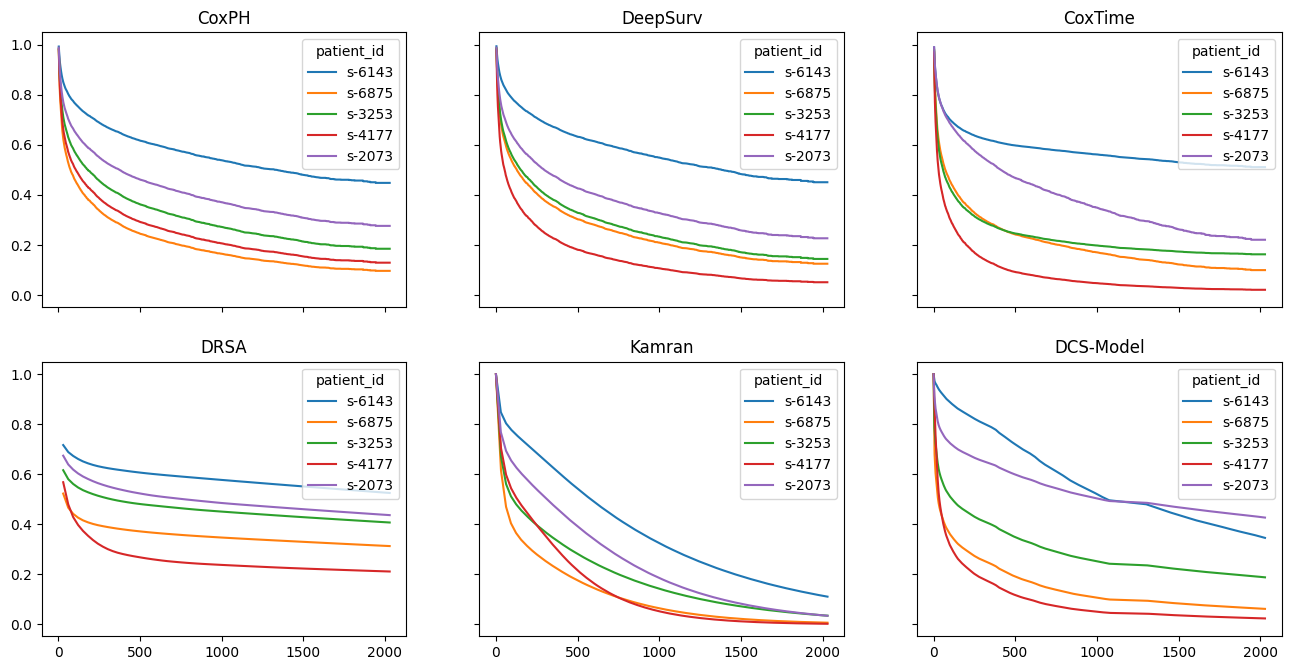

In [12]:
import matplotlib.pyplot as plt

sample_idx = test_X.sample(5).index

nrows=int(np.ceil(len(predictions)/3))

fig, axs = plt.subplots(
    figsize=(16, 4*nrows), dpi=100, 
    ncols=3, nrows=nrows,
    sharex=True, sharey=True)
axs = axs.reshape(-1)

for i, (model_name, prediction) in enumerate(predictions.items()):
    ax = axs[i]
    prediction.loc[sample_idx].T.plot(ax=ax)
    ax.set_title(model_name)


## Quantitative

In [13]:
results_df = pd.DataFrame()
for model_name, prediction in predictions.items():

    results_model = pd.Series({
        "c-index-td": dcs.evaluation.concordance_index_td(test_y, prediction),
        "cdauc": dcs.evaluation.cdauc(test_y, prediction),
        "ddc": dcs.evaluation.ddc(test_y, prediction),
    }, name=model_name)
    
    results_df = results_df.append(results_model)


display(results_df.T)

/home/pfuhlert/src/discrete-calibrated-survival/dcs/evaluation.py:97: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/home/pfuhlert/src/discrete-calibrated-survival/dcs/evaluation.py:97: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,CoxPH,DeepSurv,CoxTime,DRSA,Kamran,DCS-Model
c-index-td,0.595550,0.604897,0.616519,0.582324,0.600931,0.621841
cdauc,0.621955,0.637521,0.655772,0.586694,0.632761,0.638779
ddc,0.004974,0.005403,0.008125,0.269031,0.052000,0.036946
